# Example: Lava World using Q-Learning and SARSA
Fill me in

## Setup

In [1]:
include("CHEME-5760-L13a-CodeLib.jl");

In [2]:
using Plots
using Colors

## Task 1: Build the Grid World

In [3]:
# Step 1: Build a model of the world -
number_of_rows = 10
number_of_cols = 10
nactions = 4; 
nstates = (number_of_rows*number_of_cols);
𝒮 = range(1,stop=nstates,step=1) |> collect;
𝒜 = range(1,stop=nactions,step=1) |> collect;

# setup rewards -
lava_reward = -1000.0;
charging_reward = 100.0;

# setup rewards -
rewards = Dict{Tuple{Int,Int}, Float64}()
rewards[(5,5)] =  lava_reward # lava in the (5,5) square 
rewards[(6,5)] = lava_reward # lava in the (6,5) square
rewards[(6,6)] = lava_reward # lava in the (6,6) square
rewards[(5,6)] = charging_reward    # charging station square

# setup set of absorbing states -
absorbing_state_set = Set{Tuple{Int,Int}}()
push!(absorbing_state_set, (5,5));
push!(absorbing_state_set, (6,5));
push!(absorbing_state_set, (6,6));
push!(absorbing_state_set, (5,6));

# walls?
soft_wall_set = Set{Tuple{Int,Int}}();

In [4]:
# call the factory -
world_model = build(MyRectangularGridWorldModel, (
        nrows=number_of_rows, ncols=number_of_cols, rewards = rewards, defaultreward = -1.0));

## Task 2: Build the Q-learning agent

In [5]:
α = 0.70;  # learning rate
γ = 0.95; # discount rate
nstates = (number_of_rows*number_of_cols);
agent_model = build(MyQLearningAgentModel, (
    states = range(1,stop=nstates,step=1) |> collect,
    actions = range(1,stop=nactions,step=1) |> collect,
    α = α,
    γ = γ,
    Q = zeros(nstates,nactions)
));

## Task 3: Simulate

In [34]:
startstate = (1,1); # start position
number_of_iterations = 5000;
result = simulate(agent_model, world_model, startstate, number_of_iterations, ϵ = 0.4);
Q = result.Q;
my_π = policy(Q);

In [35]:
s = world_model.states[(4,10)]

40

In [27]:
Q[40,:]

4-element Vector{Float64}:
  -1.51515
  -0.7
 676.6239998536944
   0.0

In [13]:
move_arrows = Dict{Int,Any}();
move_arrows[1] = "←"
move_arrows[2] = "→"
move_arrows[3] = "↓"
move_arrows[4] = "↑"
move_arrows[5] = "∅";

for s ∈ 𝒮
    a = my_π[s];
    Δ = world_model.moves[a];
    current_position = world_model.coordinates[s]
    new_position =  current_position .+ Δ
    
    if (in(current_position, absorbing_state_set) == true)
        println("$(current_position) $(move_arrows[5])")
    else
        println("$(current_position) $(move_arrows[a]) $(new_position)")
    end
end

(1, 1) → (2, 1)
(1, 2) → (2, 2)
(1, 3) ↑ (1, 4)
(1, 4) ↑ (1, 5)
(1, 5) → (2, 5)
(1, 6) ↓ (1, 5)
(1, 7) → (2, 7)
(1, 8) ↑ (1, 9)
(1, 9) → (2, 9)
(1, 10) → (2, 10)
(2, 1) ← (1, 1)
(2, 2) ← (1, 2)
(2, 3) ← (1, 3)
(2, 4) → (3, 4)
(2, 5) → (3, 5)
(2, 6) → (3, 6)
(2, 7) ↓ (2, 6)
(2, 8) ↑ (2, 9)
(2, 9) ← (1, 9)
(2, 10) → (3, 10)
(3, 1) ← (2, 1)
(3, 2) → (4, 2)
(3, 3) → (4, 3)
(3, 4) ↑ (3, 5)
(3, 5) → (4, 5)
(3, 6) → (4, 6)
(3, 7) → (4, 7)
(3, 8) → (4, 8)
(3, 9) → (4, 9)
(3, 10) → (4, 10)
(4, 1) ← (3, 1)
(4, 2) → (5, 2)
(4, 3) ↑ (4, 4)
(4, 4) ↑ (4, 5)
(4, 5) ↑ (4, 6)
(4, 6) → (5, 6)
(4, 7) ↓ (4, 6)
(4, 8) → (5, 8)
(4, 9) → (5, 9)
(4, 10) ↑ (4, 11)
(5, 1) ↑ (5, 2)
(5, 2) ↓ (5, 1)
(5, 3) ↑ (5, 4)
(5, 4) ← (4, 4)
(5, 5) ∅
(5, 6) ∅
(5, 7) ↓ (5, 6)
(5, 8) ↓ (5, 7)
(5, 9) ↓ (5, 8)
(5, 10) ← (4, 10)
(6, 1) ↑ (6, 2)
(6, 2) ← (5, 2)
(6, 3) ↓ (6, 2)
(6, 4) ← (5, 4)
(6, 5) ∅
(6, 6) ∅
(6, 7) ← (5, 7)
(6, 8) ↓ (6, 7)
(6, 9) ← (5, 9)
(6, 10) ← (5, 10)
(7, 1) ↑ (7, 2)
(7, 2) ↓ (7, 1)
(7, 3) ↑ (7, 4)
(7, 4) ←

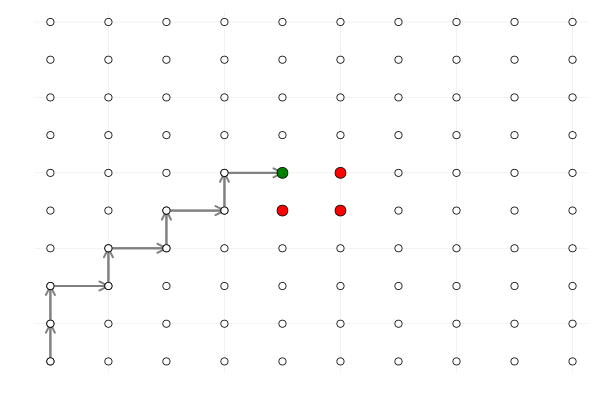

In [38]:
# setup -
# draw the path -
p = plot();
initial_site = (1,1)
hit_absorbing_state = false
s = world_model.states[initial_site];
visited_sites = Set{Tuple{Int,Int}}();
push!(visited_sites, initial_site);

while (hit_absorbing_state == false)
    current_position = world_model.coordinates[s]
    a = my_π[s];
    Δ = world_model.moves[a];
    new_position =  current_position .+ Δ
    scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:black, c=:blue)
    plot!([current_position[1], new_position[1]],[current_position[2],new_position[2]], label="", arrow=true, lw=2, c=:gray)
    
    if (in(new_position, absorbing_state_set) == true || in(new_position, visited_sites) == true)
        hit_absorbing_state = true;
    else
        s = world_model.states[new_position];
        push!(visited_sites, new_position);
    end
end

# draw the grid -
for s ∈ 𝒮
    current_position = world_model.coordinates[s]
    a = my_π[s];
    Δ = world_model.moves[a];
    new_position =  current_position .+ Δ
    
    if (haskey(rewards, current_position) == true && rewards[current_position] == charging_reward)
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:green, ms=6)
    elseif (haskey(rewards, current_position) == true && rewards[current_position] == lava_reward)
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:red, ms=6)
    elseif (in(current_position, soft_wall_set) == true)
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:gray69, ms=6)
    else
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:black, c=:white)
    end
end
current()